In [2]:
import matplotlib.pyplot as plt
def tissue_colors():
    
    tissue_color_dict = {'Bladder': '#e7969c',
             'Blood': '#d6616b',
             'Bone_Marrow': '#cedb9c',
             'Eye': '#c7ea46',#"#00ff7f",
             'Fat': '#e7cb94',
             'Heart': '#ff0800',
             'Kidney': '#7b4173',
             'Large_Intestine': '#31a354',
             'Liver': '#000080',
             'Lung': '#3182bd',
             'Lymph_Node': '#8c6d31',
             'Mammary':'#ce6dbd',
             'Muscle': '#e7ba52',
             'Pancreas': '#fd8d3c',
             'Prostate':'#637939',#'#a55194',#
             'Salivary_Gland':'#622a0f',
             'Skin': '#de9ed6',
             'Small_Intestine': '#6baed6',
             'Spleen': '#393b79',
             'Thymus': '#9c9ede',
             'Tongue':'#b5cf6b',
             'Trachea': '#969696',
             'Uterus':'#c64b8c',#'#ff0090',
             'Vasculature': '#843c39'}
    
    return tissue_color_dict

### BtReceptor Edited for T cell data 

from __future__ import division
import pandas as pd
import numpy as np
import Levenshtein
from scipy.spatial.distance import squareform
from scipy.sparse.csgraph import connected_components
from itertools import combinations


def df_pw_edit(frame):
    """ Returns array of pairwise edit distances in square form """

    ed = np.zeros(int((frame.shape[0]/2)*(frame.shape[0]-1)), dtype='float')
    for c, (x, y) in enumerate(combinations(frame.cdr3.values, 2)):
        ed[c] = Levenshtein.distance(x, y) / np.max([len(x), len(y)])
    sq = squareform(ed)

    return sq


def df_lineages_from_subset(frame, similarity_cutoff):
    """ Returns an array of lineage membership based on a CDR3 cutoff """

    edit_sq = df_pw_edit(frame)

    n_groups, labels = connected_components(edit_sq <= round(1 - similarity_cutoff, 4))

    return labels


def df_add_lineages(dfin, similarity_cutoff):
    """ Returns input dataframe with additional lineage column
    Args:
        similarity_cutoff (float): e.g. 0.8 for 80% minimum cdr3aa similarity
    """

    dfin = dfin.copy()

    # unique index required for join
    if not dfin.index.is_unique:
        print("Input DataFrame index not unique, applying reset_index().")
        dfin.reset_index(drop=True, inplace=True)

    lincnt = 0
    lins = []

    for (v, j, _), sub in dfin.groupby(['v_call',
                                       'j_call',
                                       'cdr3nt_len']):
        if sub.shape[0] > 1:
            # CDR3 distance comparisoin
            sub_lineages = df_lineages_from_subset(sub, similarity_cutoff)
            lins += zip(sub.index, sub_lineages + lincnt)
            lincnt += np.unique(sub_lineages).shape[0]
        else:
            # single sequence belongs in its own lineage
            lins.append((sub.index.values[0], lincnt))
            lincnt += 1

    # adds a "lineage" column corresponding to the lineage number for that cell
    lins = pd.DataFrame(lins, columns=['index', 'lineage']).set_index('index')
    if 'lineage' in dfin.columns:
        dfin = dfin.drop('lineage', axis=1).join(lins)
    else:
        dfin = dfin.join(lins)

    return dfin


def donor_colors():
    donors = ['TSP1','TSP2','TSP3','TSP4','TSP5','TSP6','TSP7','TSP8','TSP9','TSP10','TSP11','TSP12','TSP13','TSP14','TSP15']
    
    import matplotlib.colors as pltcolors
    
    cmap = plt.cm.get_cmap("YlGnBu")
        
    donor_color_dict = {}
    j=1/len(donors)
    for d in donors:
        donor_color_dict[d] = pltcolors.to_hex(cmap(j))
        j+=1/len(donors)
        
    return donor_color_dict

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns

import plotly
import plotly.graph_objects as go

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
    }
mpl.rcParams.update(params)
SMALL_SIZE = 20
MEDIUM_SIZE = 22
BIGGER_SIZE = 24
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")
sns.set_palette('colorblind')

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "figures"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Sankey Diagram

In [4]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        print(idx, colorNum)
        colorList = colorList + [colorPalette[idx]]*colorNum
        print(colorList)
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

## My Data

In [5]:
df = pd.read_table('../data/merged_airr.tsv')

In [175]:
df = pd.read_csv('../TSP1.2.Immune.withLineages.obs.csv')

/home/mswift/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning:

Columns (2,3,4,5,6,13,14,15,17,65,66,67,69,70,71,73,74) have mixed types.Specify dtype option on import or set low_memory=False.



,sequence_id,sequence,locus,stop_codon,vj_in_frame,productive,rev_comp,v_call,d_call,j_call,sequence_alignment,germline_alignment,sequence_alignment_aa,germline_alignment_aa,v_alignment_start,v_alignment_end,d_alignment_start,d_alignment_end,j_alignment_start,j_alignment_end,v_sequence_alignment,v_sequence_alignment_aa,v_germline_alignment,v_germline_alignment_aa,d_sequence_alignment,d_sequence_alignment_aa,d_germline_alignment,d_germline_alignment_aa,j_sequence_alignment,j_sequence_alignment_aa,j_germline_alignment,j_germline_alignment_aa,fwr1,fwr1_aa,cdr1,cdr1_aa,fwr2,fwr2_aa,cdr2,cdr2_aa,fwr3,fwr3_aa,fwr4,fwr4_aa,cdr3,cdr3_aa,junction,junction_length,junction_aa,junction_aa_length,v_score,d_score,j_score,v_cigar,d_cigar,j_cigar,v_support,d_support,j_support,v_identity,d_identity,j_identity,v_sequence_start,v_sequence_end,v_germline_start,v_germline_end,d_sequence_start,d_sequence_end,d_germline_start,d_germline_end,j_sequence_start,j_sequence_end,j_germline_start,j_germline_end,fwr1_start,fwr1_end,cdr1_start,cdr1_end,fwr2_start,fwr2_end,cdr2_start,cdr2_end,fwr3_start,fwr3_end,fwr4_start,fwr4_end,cdr3_start,cdr3_end,np1,np1_length,np2,np2_length,library,contig_id,high_confidence,umis,reads,cell_id_x,cell_id_y,donor,tissue,anatomical_position,method,cell_ontology_class,free_annotation,consensus_prediction,consensus_percentage,manually_annotated,10X_run,10X_sample,10X_replicate,10X_barcode,cDNAplate,libraryplate,well,notes,seqrun,cell_identifier,n_counts,n_genes,_cell_id
0,AAAGTAGGTGTGGCTC-1_contig_1_TSP2_BM_vertebralb...,TGGGGGTAGCTCAGGAAGCAGAGCCTGGAGCATCTCCACTATGGCC...,IGL,F,T,T,F,IGLV6-57*01,NaN,IGLJ3*02,TTTATACTGACCCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,TTTATGCTGACTCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FILTQPHSVSESPGKTVTISCTRSSGDIVSNYVQWYQQRPGSSPTI...,FMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSSPTT...,1.0,282.0,NaN,NaN,298.0,329.0,TTTATACTGACCCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FILTQPHSVSESPGKTVTISCTRSSGDIVSNYVQWYQQRPGSSPTI...,TTTATGCTGACTCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSSPTT...,NaN,NaN,NaN,NaN,GTGTTCGGCACAGGGACCAAACTGACCGTCCT,VFGTGTKLTVL,GTGTTCGGCGGAGGGACCAAGCTGACCGTCCT,VFGGGTKLTVL,TTTATACTGACCCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FILTQPHSVSESPGKTVTISCTRS,AGTGGCGACATCGTAAGCAACTAT,SGDIVSNY,GTACAGTGGTATCAACAGCGCCCGGGCAGTTCCCCCACCATTTTGA...,VQWYQQRPGSSPTILIF,GAACATAGT,EHS,CGAAGACCCTCTGGGGTCCCTAATCGATTCTCTGGCTCCGTCGACG...,RRPSGVPNRFSGSVDGSSDSASLTISGLETEDEADYYC,TTCGGCACAGGGACCAAACTGACCGTCCT,FGTGTKLTVL,CACTCTTATGATTCTTTCCATCGTGGAGTG,HSYDSFHRGV,TGTCACTCTTATGATTCTTTCCATCGTGGAGTGTTC,36.0,CHSYDSFHRGVF,12.0,344.621,NaN,44.909,100S3N282M260S11N,NaN,397S4N32M213S2N,1.781000e-96,NaN,2.051000e-08,89.007,NaN,90.625,101.0,382.0,4.0,285.0,NaN,NaN,NaN,NaN,398.0,429.0,5.0,36.0,101.0,172.0,173.0,196.0,197.0,247.0,248.0,256.0,257.0,370.0,401.0,429.0,371.0,400.0,TCTTTCCATCGTGGA,15.0,NaN,NaN,10X_vdj,AAAGTAGGTGTGGCTC-1_contig_1,True,204.0,2343.0,AAAGTAGGTGTGGCTC_TSP2_BM_vertebralbody_10X_5prime,AAAGTAGGTGTGGCTC_TSP2_BM_vertebralbody_10X_2_2...,TSP2,Bone_Marrow,vertebralbody,10X,plasma cell,plasma cell,plasma cell,1.00,True,NaN,NaN,NaN,AAAGTAGGTGTGGCTC_TSP2_BM_vertebralbody_10X_2_2...,NaN,NaN,NaN,5prime,2.0,AAAGTAGGTGTGGCTC_TSP2_BM_vertebralbody_10X_2_2...,15471.0,1484,AAAGTAGGTGTGGCTC_TSP2_BM_vertebralbody_10X_5prime
1,AAAGTAGGTGTGGCTC-1_contig_1_TSP2_BM_vertebralb...,GGGGGGTAGCTCAGGAAGCAGAGCCTGGAGCATCTCCACTATGGCC...,IGL,F,T,T,F,IGLV6-57*01,NaN,IGLJ3*02,TTTATACTGACCCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,TTTATGCTGACTCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FILTQPHSVSESPGKTVTISCTRSSGDIVSNYVQWYQQRPGSSPTI...,FMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSSPTT...,1.0,282.0,NaN,NaN,298.0,329.0,TTTATACTGACCCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FILTQPHSVSESPGKTVTISCTRSSGDIVSNYVQWYQQRPGSSPTI...,TTTATGCTGACTCAGCCCCACTCTGTGTCGGAGTCTCCGGGGAAGA...,FMLTQPHSVSESPGKTVTISCTRSSGSIASNYVQWYQQRPGSSPTT...,NaN,NaN,NaN,NaN,GTGTTCGGCACAGGGACCAAACTGACCGTCCT,VFGTGTKLTVL,GTGTTCGGCGGAGGGACCAAGCTGACCGTCCT,VFGGGTKLTVL,TTTATACTGACCCAGCCCCAC

In [176]:
Tcells = df[~df.lineage.isna()]

<AxesSubplot:xlabel='annotation_oct2020'>

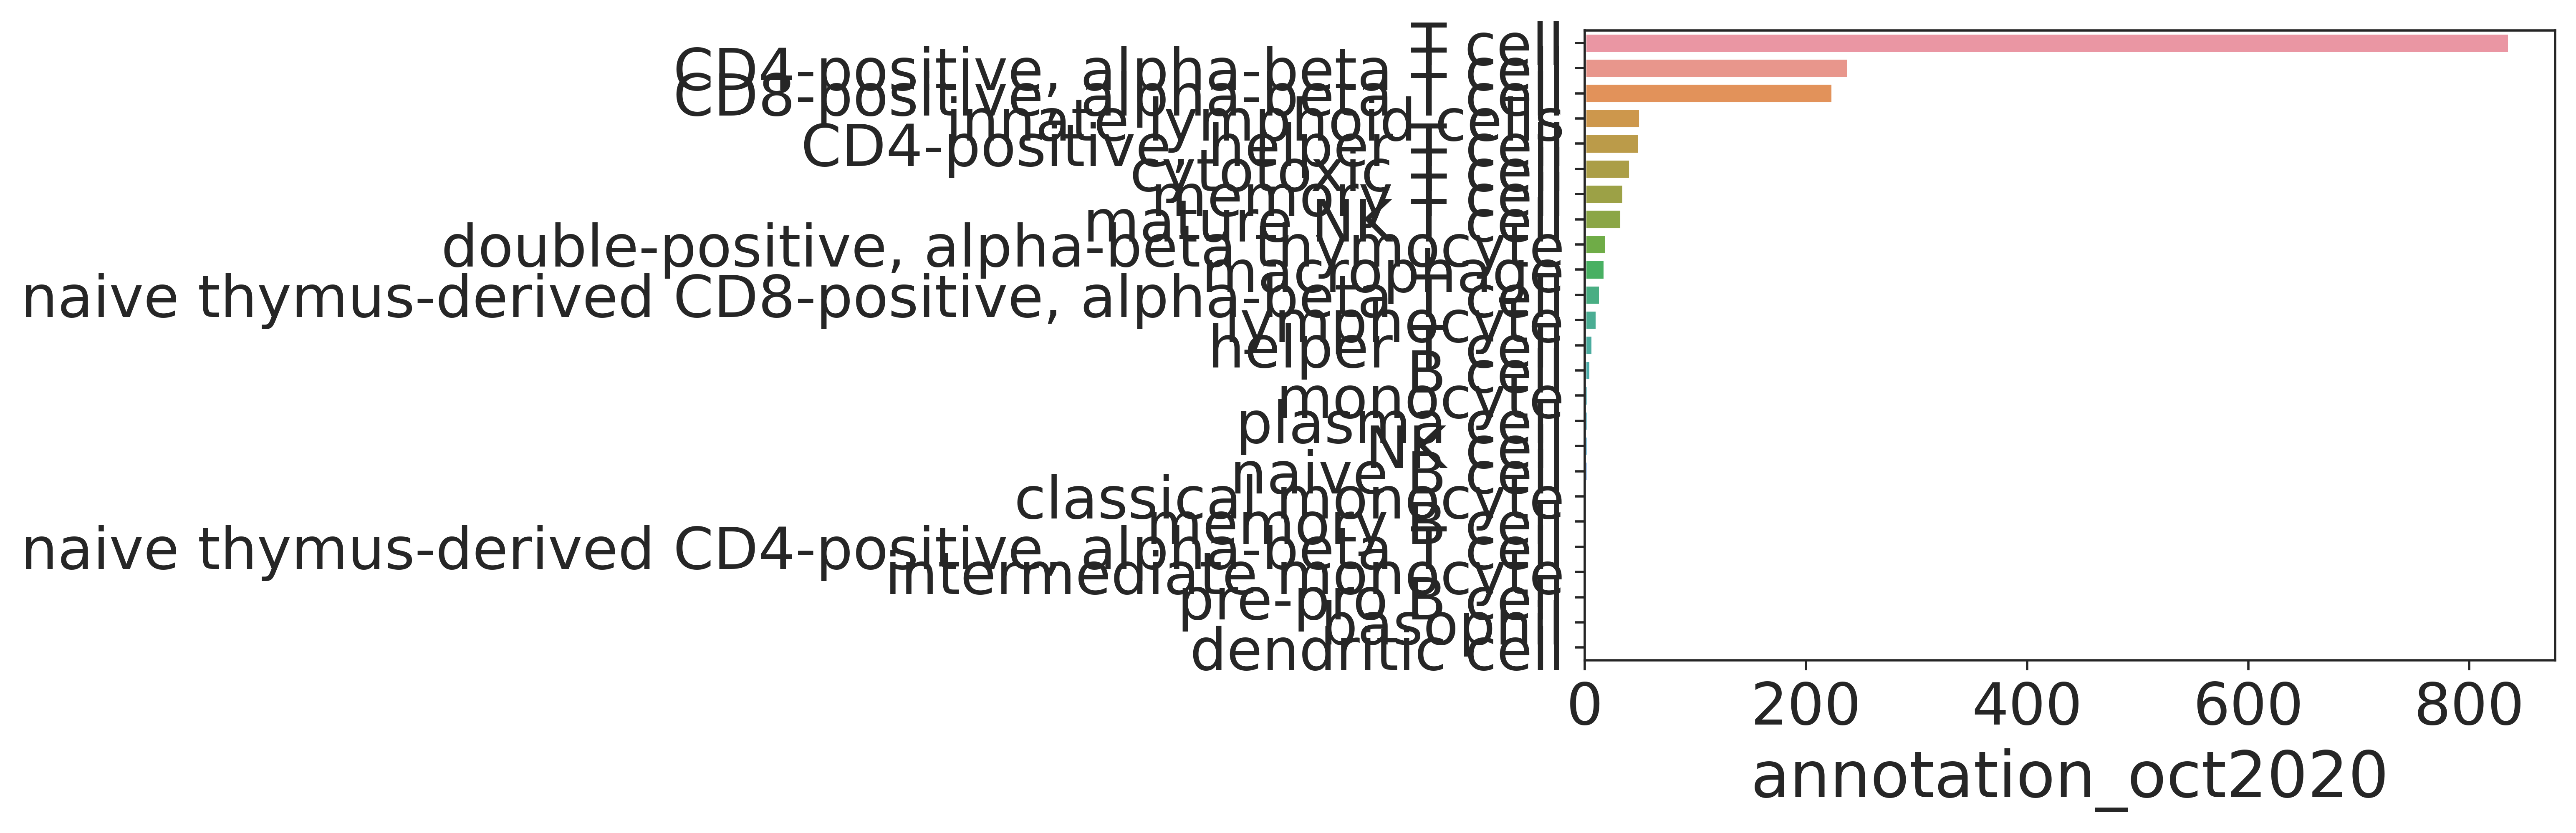

In [189]:

data = pd.DataFrame(Tcells.annotation_oct2020.value_counts())

sns.barplot(x = data.annotation_oct2020, y = data.index)

In [144]:
Tcells.groupby('donor').tissue.value_counts()

donor  tissue     
TSP1   Muscle          52
       Blood           47
       Lung            19
       Pancreas         3
TSP2   Thymus         452
       Blood          331
       Lymph_Node     284
       Bone_Marrow    207
       Spleen          98
       Muscle          62
       Kidney          37
       Vasculature      6
       Bladder          4
Name: tissue, dtype: int64

df = pd.read_csv('../../data/repertoire/output/TCellClonality.csv')

df = pd.read_csv('working_data_object_TSP1TSP2_Achainonly.csv', index_col=0)
df = pd.read_csv('1only.csv', index_col=0)


df['tissue'] = df['tissue_x']

df_lineages.lineage.value_counts()

In [152]:
df['my_leiden'].value_counts()

0     6984
1     6361
2     4400
3     4228
4     4025
5     3115
6     3023
7     2845
8     2725
9     2604
10    2480
11    2449
12    2326
13    2101
14    1882
15    1818
16    1718
17    1589
18    1568
19    1552
20    1537
21    1478
22    1413
23    1279
24    1232
25    1161
26    1084
27    1002
28     969
29     880
30     866
31     812
32     770
33     705
34     674
35     650
36     628
37     622
38     563
39     450
40     363
41     305
42     295
43     289
44     239
45     223
46     214
47     192
48     176
49      88
50      80
51      63
52      25
Name: my_leiden, dtype: int64

In [154]:
df.lineage.value_counts()

530.0     62
112.0     24
111.0     12
555.0     12
490.0      9
          ..
58.0       1
1984.0     1
1842.0     1
329.0      1
640.0      1
Name: lineage, Length: 1369, dtype: int64

In [165]:
df_lineages.lineage.value_counts()

530.0     62
112.0     24
555.0     12
111.0     12
490.0      9
937.0      9
1075.0     6
557.0      6
1571.0     6
1394.0     6
815.0      5
1240.0     5
Name: lineage, dtype: int64

In [166]:
selector = df.lineage.value_counts() > 6

lineages = selector[selector == True].index

df_lineages = df[df.lineage.isin(lineages)]
df_lineages = df_lineages[~df_lineages.tissue.isin(['Fat', 'Heart', 'Skin'])]

forSankey = df_lineages.groupby(['lineage', 'annotation_oct2020']).tissue.value_counts()

forSankey = pd.DataFrame(forSankey)

forSankey.columns = ['counts']

forSankey.reset_index(inplace = True)

forSankey.tissue = forSankey.tissue.str.replace('BM', 'Bone_Marrow')

forSankey.tissue = forSankey.tissue.str.replace('LymphNode', 'Lymph_Node')

fig = genSankey(forSankey, cat_cols=['tissue', 'lineage', 'annotation_oct2020'],
                value_cols='counts', 
                title='Clones')

0 8
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE']
1 6
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998']
2 9
['#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#4B8BBE', '#306998', '#306998', '#306998', '#306998', '#306998', '#306998', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873', '#FFE873']


### tweak the plot characteristics

In [169]:
import plotly.express as px

_dict

cell_type_colors = dict(zip(list(df_lineages.my_leiden.unique()), px.colors.qualitative.Dark24[:]))
cell_type_colors = dict(zip(list(df_lineages.annotation_oct2020.unique()), px.colors.qualitative.Dark24[:]))

In [170]:
# Increase the font size
fig['layout']['font']['size'] = 18
# Update colors to be the TS colors
_num_tissues = df_lineages.tissue.unique().shape[0]
_num_lineages = df_lineages.lineage.unique().shape[0]
# Breaks if there are too many lineages involved
_dict = dict(zip(list(df_lineages.lineage.unique()), px.colors.qualitative.Alphabet[:]))

_dict.update(tissue_colors())
_dict.update(cell_type_colors)

# create color list according to color dictionary
old_dict = dict(zip(fig['data'][0]['node']['label'], fig['data'][0]['node']['color']))


new_dict = {key: _dict[key] for key, value in old_dict.items()}

fig['data'][0]['node']['color'] = list(new_dict.values())

In [7]:
plotly.offline.plot(fig, image_height=800, image_width=2000, validate=False, image='svg')

NameError: name 'fig' is not defined

,cell_id,X10X_run,smartseq2_barcode,smartseq2_library_plate,smartseq2_sorting_direction,smartseq2_sort_order,smartseq2_cDNA_Plate,method,donor,X10X_replicate,sequencer,sex,tissue,smartseq2_well_seq,notes,smartseq2_sorted_population,X10X_sample,anatomical_position,X10X_barcode,n_counts,n_genes,manual_cell_ontology_class,manual_annotation,doublet_filter,compartment,batch,compartment_pred,leiden,cluster_id,Propagated.Annotation,Entropy.All.Methods,Entropy.kNN.Reps,Entropy.scANVI.Reps,Entropy.SVM.Reps,Potential.Doublets,Onclass,singlecellNet,kNN,SVM,scANVI,compartment_pred_svm,manual_cell_ontology_classcollapsed,Propagated.Annotationcollapsed,Onclasscollapsed,singlecellNetcollapsed,kNNcollapsed,SVMcollapsed,scANVIcollapsed,miscompartmentalized,log_n_counts,log_n_genes,donor_method,decontX_contamination,decontX_clusters,sftpb,sftpc,contamination_prop,_scvi_batch,_scvi_labels,_scvi_local_l_mean,_scvi_local_l_var,annotation_oct2020,compartment_oct2020,cell_ontology_type,df_merge,cell_name,v_call_no_allele_A_Chain,j_call_no_allele_A_Chain,cdr3nt_len_A_Chain,cdr3nt_A_Chain,v_call_no_allele_B_Chain,j_call_no_allele_B_Chain,cdr3nt_len_B_Chain,cdr3nt_B_Chain,metadata_B_Chain,lineage,Unnamed: 0,cell type,PropAnno,SubCellType,my_leiden
0,B107821_A17_S13.homo.gencode.v30.ERCC.chrM,NaN,BC17,B107821Blue,Row,Plate 4,B107821,smartseq2,TSP1,NaN,novaseq,female,Bladder,A17,"failed library prep, redo",Endothelial,NaN,NaN,NaN,2708453.0,1153,unassigned,unassigned,0,Immune,0,Stromal,25,27,plasma cell,0.950271,-0.000000,0.610864,-0.000000,0,plasma cell,rand,B cell,plasma cell,plasma cell,Immune,unassigned,plasma cell,plasma cell,rand,B cell,plasma cell,plasma cell,0,14.811889,7.807917,TSP1smartseq2,6.456519e-05,TSP1smartseq2-plasma cell,NaN,NaN,1.624063e-04,0,0,13.004389,1.978991,plasma cell,Immune,plasma cell,B107821_A17_S13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17
1,B107821_A18_S14.homo.gencode.v30.ERCC.chrM,NaN,BC17,B107821Blue,Row,Plate 4,B107821,smartseq2,TSP1,NaN,novaseq,female,Bladder,A18,"failed library prep, redo",Endothelial,NaN,NaN,NaN,897507.0,2516,unassigned,unassigned,0,Immune,0,Immune,25,27,plasma cell,-0.000000,-0.000000,-0.000000,-0.000000,0,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,Immune,unassigned,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,0,13.707376,7.932003,TSP1smartseq2,2.093677e-02,TSP1smartseq2-plasma cell,NaN,NaN,3.808193e-03,0,0,13.004389,1.978991,plasma cell,Immune,plasma cell,B107821_A18_S14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19
2,B107821_A5_S1.homo.gencode.v30.ERCC.chrM,NaN,BC17,B107821Blue,Row,Plate 4,B107821,smartseq2,TSP1,NaN,novaseq,female,Bladder,A5,"failed library prep, redo",Endothelial,NaN,NaN,NaN,1013171.0,859,unassigned,unassigned,0,Immune,0,Immune,25,27,plasma cell,0.950271,-0.000000,0.500402,-0.000000,0,plasma cell,rand,B cell,plasma cell,plasma cell,Immune,unassigned,plasma cell,plasma cell,rand,B cell,plasma cell,plasma cell,0,13.828595,7.433667,TSP1smartseq2,5.845386e-05,TSP1smartseq2-plasma cell,NaN,NaN,1.416694e-04,0,0,13.004389,1.978991,plasma cell,Immune,plasma cell,B107821_A5_S1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
3,B107821_B10_S29.homo.gencode.v30.ERCC.chrM,NaN,BC17,B107821Blue,Row,Plate 4,B107821,smartseq2,TSP1,NaN,novaseq,female,Bladder,B10,"failed library prep, redo",Endothelial,NaN,NaN,NaN,845064.0,2078,unassigned,unassigned,0,Immune,0,Stromal,25,27,plasma cell,-0.000000,-0.000000,-0.000000,-0.000000,0,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,Immune,unassigned,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,plasma cell,0,13.647167,7.757479,TSP1smartseq2,5.999458e-02,TSP1smartseq2-plasma cell,NaN,NaN,6.685103e-03,0,0,13.004389,1.978991,plasma cell,Immune,plasma cell,B107821_B10_S29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
4,B107821_B14_S33.homo.gencode.v30.ERCC.chrM,NaN,BC17,B107821Blue,Row,Plate 4,B107821,smartseq2,TSP1,NaN,nov